In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

In [1]:
data ='https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
!wget = $data

--2025-10-19 02:46:49--  http://=/
Resolving = (=)... failed: Name or service not known.
wget: unable to resolve host address ‘=’
--2025-10-19 02:46:49--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.002s  

2025-10-19 02:46:49 (45.4 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]

FINISHED --2025-10-19 02:46:49--
Total wall clock time: 0.07s
Downloaded: 1 files, 79K in 0.002s (45.4 MB/s)


In [2]:
df= pd.read_csv('course_lead_scoring.csv')
df.head()                
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [3]:
#prepare the data with appropiate cleanups
df.columns = df.columns.str.lower().str.replace(' ','_')
#replace nan in categorial columns with NA and numerical with 0.0
cat_cols = list(df.dtypes[df.dtypes=='object'].index)
num_cols = df.select_dtypes(include=['number']).columns
df[cat_cols]= df[cat_cols].fillna('NA')
df[num_cols]= df[num_cols].fillna(0.0)
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [8]:
#spit the dataset into train,val and test
#60% 20% 20% and random_state=1
df_train_data_full, df_test = train_test_split(df, test_size=0.2,random_state=1)
df_train,df_val =  train_test_split(df_train_data_full, test_size=0.25,random_state=1)
df_train.shape,df_val.shape,df_test.shape
#extract and remove the target values from the data split
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values
del df_train['converted']
del df_val['converted']
del df_test['converted']
feature_auc = {}

In [9]:
# implement ROC Auc feature impotance to find the highest AUC among numerical variable.
auc = roc_auc_score(y_train,df_train['lead_score'])
print('lead_score_auc:', auc)
auc = roc_auc_score(y_train,df_train['number_of_courses_viewed'])
print('number_of_courses_viewed_auc:', auc)
auc = roc_auc_score(y_train,df_train['interaction_count'])
print('interaction_countd_auc:', auc)
auc = roc_auc_score(y_train,df_train['annual_income'])
print('annual_income_auc:', auc)

lead_score_auc: 0.6144993577250176
number_of_courses_viewed_auc: 0.7635680590007088
interaction_countd_auc: 0.738270176293409
annual_income_auc: 0.5519578313253012


In [ ]:
#according to the auc values number_of_courses_viewed has the highest auc value
num_cols =num_cols.drop(['converted'])

In [14]:
#Apply one-hot-encoding using DictVectorizer and train the logistic regression
#remove the target columns out of numerical categories
train_dicts = df_train[cat_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
encoded_cat =dv.fit_transform(train_dicts)
encoded_df = pd.DataFrame(encoded_cat, columns=dv.get_feature_names_out(cat_cols))
#concat categorical data with numerical data
X_train = pd.concat([df_train[num_cols].reset_index(drop=True),encoded_df.reset_index(drop=True)], axis=1)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [17]:
#find the auc of the model using the validation data
# one-hot-encode the validation dataset using dictVectorizer
train_val = df_val[cat_cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
encoded_cat =dv.fit_transform(train_val)
encoded_df = pd.DataFrame(encoded_cat, columns=dv.get_feature_names_out(cat_cols))
X_val = pd.concat([df_val[num_cols].reset_index(drop=True),encoded_df.reset_index(drop=True)], axis=1)
#find the prediction using the validation dataset
y_pred_proba = model.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
print('model_auc:',round(auc,3))

model_auc: 0.817


In [ ]:
# the model auc is 0.82

In [20]:
#compute precision and recall for our model
#Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.00, 0.01)
precision_list = []
recall_list = []
for t in thresholds:
    y_pred = (y_pred_proba >= t).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    precision_list.append(precision)
    recall_list.append(recall)

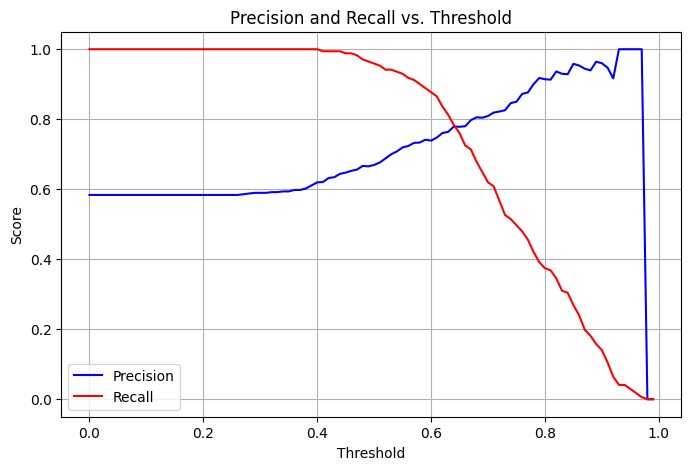

In [22]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precision_list, label='Precision', color='blue')
plt.plot(thresholds, recall_list, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#At which threshold precision and recall curves intersect?
#accoding to the graph is approximately around 0.71